# **3. Correlation and PPS Notebook**

## Objectives

* Carry out regression and PPS analysis to prepare data for modelling

## Inputs

* Based on the cleaned dataset (HousePrices.csv)

## Outputs

* Regression and PPS outputs


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [81]:
import os

# Get the current directory
current_dir = os.getcwd()
print("Current Directory:", current_dir)

# Change the directory to the new path
os.chdir('/workspace/milestone-project-housing-issues')

# Get the updated current directory
current_dir = os.getcwd()
print("New Current Directory:", current_dir)

Current Directory: /workspace/milestone-project-housing-issues
New Current Directory: /workspace/milestone-project-housing-issues


In [82]:
# Import packages for correlation analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Load and Inspect Dataset

Load dataset and confirm no missing data

In [83]:
# Load dataset
import pandas as pd
df_houseprices = pd.read_csv(f"/workspace/milestone-project-housing-issues/outputs/datasets/cleaned/HousePricesClean.csv")
df_houseprices.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,No,706,GLQ,150,548,RFn,2003,...,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,756,3,Gd,978,ALQ,284,460,RFn,1976,...,9600,80,554,56,8,6,1262,1976,1976,181500
2,920,866,3,Mn,486,GLQ,434,608,RFn,2001,...,11250,68,162,42,5,7,920,2001,2002,223500
3,961,1040,2,No,216,ALQ,540,642,Unf,1998,...,9550,60,154,35,5,7,756,1915,1970,140000
4,1145,714,4,Av,655,GLQ,490,836,RFn,2000,...,14260,84,350,84,5,8,1145,2000,2000,250000


In [84]:
# Confirm no missing data

missing_values_count = df_houseprices.isna().sum()
missing_values_count

1stFlrSF        0
2ndFlrSF        0
BedroomAbvGr    0
BsmtExposure    0
BsmtFinSF1      0
BsmtFinType1    0
BsmtUnfSF       0
GarageArea      0
GarageFinish    0
GarageYrBlt     0
GrLivArea       0
KitchenQual     0
LotArea         0
LotFrontage     0
MasVnrArea      0
OpenPorchSF     0
OverallCond     0
OverallQual     0
TotalBsmtSF     0
YearBuilt       0
YearRemodAdd    0
SalePrice       0
dtype: int64

In [85]:
df_houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1460 non-null   int64 
 1   2ndFlrSF      1460 non-null   int64 
 2   BedroomAbvGr  1460 non-null   int64 
 3   BsmtExposure  1460 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType1  1460 non-null   object
 6   BsmtUnfSF     1460 non-null   int64 
 7   GarageArea    1460 non-null   int64 
 8   GarageFinish  1460 non-null   object
 9   GarageYrBlt   1460 non-null   int64 
 10  GrLivArea     1460 non-null   int64 
 11  KitchenQual   1460 non-null   object
 12  LotArea       1460 non-null   int64 
 13  LotFrontage   1460 non-null   int64 
 14  MasVnrArea    1460 non-null   int64 
 15  OpenPorchSF   1460 non-null   int64 
 16  OverallCond   1460 non-null   int64 
 17  OverallQual   1460 non-null   int64 
 18  TotalBsmtSF   1460 non-null   int64 
 19  YearBu

#### Recoding categorical to numerical data for regression analysis

In [86]:
# Reclassifying categorical variables to 'object' type

df_houseprices[['BsmtExposure', 'BsmtFinType1', 'GarageFinish',
            'KitchenQual', 'OverallCond', 'OverallQual',]] = df_houseprices[[
            'BsmtExposure', 'BsmtFinType1', 'GarageFinish',
            'KitchenQual', 'OverallCond', 'OverallQual']].astype(object)

df_houseprices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   1stFlrSF      1460 non-null   int64 
 1   2ndFlrSF      1460 non-null   int64 
 2   BedroomAbvGr  1460 non-null   int64 
 3   BsmtExposure  1460 non-null   object
 4   BsmtFinSF1    1460 non-null   int64 
 5   BsmtFinType1  1460 non-null   object
 6   BsmtUnfSF     1460 non-null   int64 
 7   GarageArea    1460 non-null   int64 
 8   GarageFinish  1460 non-null   object
 9   GarageYrBlt   1460 non-null   int64 
 10  GrLivArea     1460 non-null   int64 
 11  KitchenQual   1460 non-null   object
 12  LotArea       1460 non-null   int64 
 13  LotFrontage   1460 non-null   int64 
 14  MasVnrArea    1460 non-null   int64 
 15  OpenPorchSF   1460 non-null   int64 
 16  OverallCond   1460 non-null   object
 17  OverallQual   1460 non-null   object
 18  TotalBsmtSF   1460 non-null   int64 
 19  YearBu

In [87]:
for col in df_houseprices.select_dtypes(include='object').columns:
    print(f"{col}: {df_houseprices[col].unique()}")

BsmtExposure: ['No' 'Gd' 'Mn' 'Av' 'None']
BsmtFinType1: ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' 'None' 'LwQ']
GarageFinish: ['RFn' 'Unf' 'Fin' 'None']
KitchenQual: ['Gd' 'TA' 'Ex' 'Fa']
OverallCond: [5 8 6 7 4 2 3 9 1]
OverallQual: [7 6 8 5 9 4 10 3 1 2]


In [88]:
# Recode to change object variables to integers

mappings = {
    'BsmtExposure': {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtFinType1': {'None': 0, 'Missing': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'GarageFinish': {'None': 0, 'Missing': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'KitchenQual': {'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4}
}

for col, mapping in mappings.items():
    df_houseprices[col] = df_houseprices[col].map(mapping).astype(int)

df_houseprices.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GarageYrBlt,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854,3,1,706,6,150,548,2,2003,...,8450,65,196,61,5,7,856,2003,2003,208500
1,1262,756,3,4,978,5,284,460,2,1976,...,9600,80,554,56,8,6,1262,1976,1976,181500
2,920,866,3,2,486,6,434,608,2,2001,...,11250,68,162,42,5,7,920,2001,2002,223500
3,961,1040,2,1,216,5,540,642,1,1998,...,9550,60,154,35,5,7,756,1915,1970,140000
4,1145,714,4,3,655,6,490,836,2,2000,...,14260,84,350,84,5,8,1145,2000,2000,250000


In [89]:
# Confirming datatypes have been changed

# print(df_houseprices[['BsmtExposure', 'BsmtFinType1', 'GarageFinish', 'KitchenQual']].dtypes)

---

# Correlation Analysis

#### Spearman Correlation Analysis

In [90]:
corr_spearman = df_houseprices.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_spearman


GrLivArea       0.731310
KitchenQual     0.672849
YearBuilt       0.652682
GarageYrBlt     0.612604
1stFlrSF        0.575408
TotalBsmtSF     0.575181
GarageFinish    0.569141
GarageArea      0.549833
LotArea         0.456461
YearRemodAdd    0.420063
Name: SalePrice, dtype: float64

#### Pearson Correlation Analysis

In [91]:
corr_pearson = df_houseprices.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson

GrLivArea       0.708624
KitchenQual     0.659600
1stFlrSF        0.605852
TotalBsmtSF     0.603505
GarageArea      0.560528
YearBuilt       0.522897
GarageYrBlt     0.508043
GarageFinish    0.490621
YearRemodAdd    0.389095
BsmtExposure    0.374696
Name: SalePrice, dtype: float64

In [92]:
# Creating combined list of top-5 correlations from spearman and pearson

top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())


{'1stFlrSF',
 'GarageArea',
 'GarageYrBlt',
 'GrLivArea',
 'KitchenQual',
 'TotalBsmtSF',
 'YearBuilt'}

### Based on the result of the correlation analysis, SalePrice appears linked to:
- The overall quality of the house
- The living area above ground (square feet)
- The quality of the kitchen
- The year the house was built
- The year the garage was built
- The size of the 1st floor (square feet)
- Total basement size (square feet)

# EDA for highly correlated variables

In [93]:
vars_to_study = ['1stFlrSF', 'GrLivArea', 'KitchenQual', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'GarageYrBlt']
vars_to_study

['1stFlrSF',
 'GrLivArea',
 'KitchenQual',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'GarageYrBlt']

In [94]:
df_houseprices_eda = df_houseprices.filter(vars_to_study + ['SalePrice'])
df_houseprices_eda.head(3)

,1stFlrSF,GrLivArea,KitchenQual,OverallQual,TotalBsmtSF,YearBuilt,GarageYrBlt,SalePrice
0,856,1710,3,7,856,2003,2003,208500
1,1262,1262,2,6,1262,1976,1976,181500
2,920,1786,3,7,920,2001,2001,223500


Adding feature 'SalePriceBand' to df_houseprices_eda to examine distribution by houseprice. Using the feature 'SalePrice' would produce too much noise due to the number of unique values.

In [95]:
# Defining min and max values
min_price = df_houseprices_eda['SalePrice'].min()
max_price = df_houseprices_eda['SalePrice'].max()

# Calculating band widths
bin_width = (max_price - min_price) / 10

# Defining bin edges
bins = [min_price + i * bin_width for i in range(11)]

# Using pd.cut to create bands and label them with numeric values
df_houseprices_eda['SalePriceBand'] = pd.cut(df_houseprices_eda['SalePrice'], bins=bins, labels=range(10), include_lowest=True)


print(df_houseprices_eda[['SalePrice', 'SalePriceBand']].head())

   SalePrice SalePriceBand
0     208500             2
1     181500             2
2     223500             2
3     140000             1
4     250000             2


In [96]:
# Checking range of values for each bin in SalePriceBand

sale_price_ranges = df_houseprices_eda.groupby('SalePriceBand')['SalePrice'].agg(['min', 'max', 'count']).sort_index()
print(sale_price_ranges)

                  min     max  count
SalePriceBand                       
0               34900  106500    148
1              107000  178900    723
2              179000  250580    373
3              251000  320000    135
4              324000  394617     51
5              395000  466500     19
6              475000  538000      4
7              555000  582933      3
8              611657  625000      2
9              745000  755000      2


In [97]:
vars_to_display =['1stFlrSF', 'GrLivArea', 'KitchenQual', 'OverallQual', 'TotalBsmtSF', 'YearBuilt', 'GarageYrBlt']
vars_to_display

['1stFlrSF',
 'GrLivArea',
 'KitchenQual',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt',
 'GarageYrBlt']

In [98]:
df_houseprices_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   1stFlrSF       1460 non-null   int64   
 1   GrLivArea      1460 non-null   int64   
 2   KitchenQual    1460 non-null   int64   
 3   OverallQual    1460 non-null   object  
 4   TotalBsmtSF    1460 non-null   int64   
 5   YearBuilt      1460 non-null   int64   
 6   GarageYrBlt    1460 non-null   int64   
 7   SalePrice      1460 non-null   int64   
 8   SalePriceBand  1460 non-null   category
dtypes: category(1), int64(7), object(1)
memory usage: 92.9+ KB


#### Variable distribution for highly correlated variables by SalePriceBand

In [99]:
df_houseprices_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   1stFlrSF       1460 non-null   int64   
 1   GrLivArea      1460 non-null   int64   
 2   KitchenQual    1460 non-null   int64   
 3   OverallQual    1460 non-null   object  
 4   TotalBsmtSF    1460 non-null   int64   
 5   YearBuilt      1460 non-null   int64   
 6   GarageYrBlt    1460 non-null   int64   
 7   SalePrice      1460 non-null   int64   
 8   SalePriceBand  1460 non-null   category
dtypes: category(1), int64(7), object(1)
memory usage: 92.9+ KB


In [100]:
# Recoding KitchenQual to object for visualisation
df_houseprices_eda['KitchenQual'] = df_houseprices_eda['KitchenQual'].astype(object)

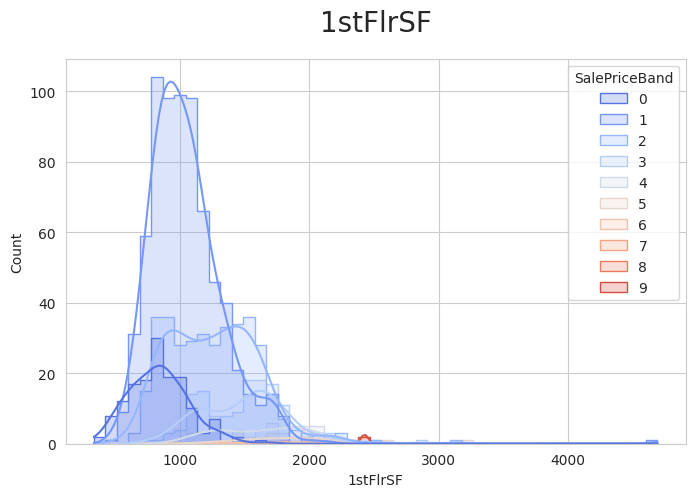

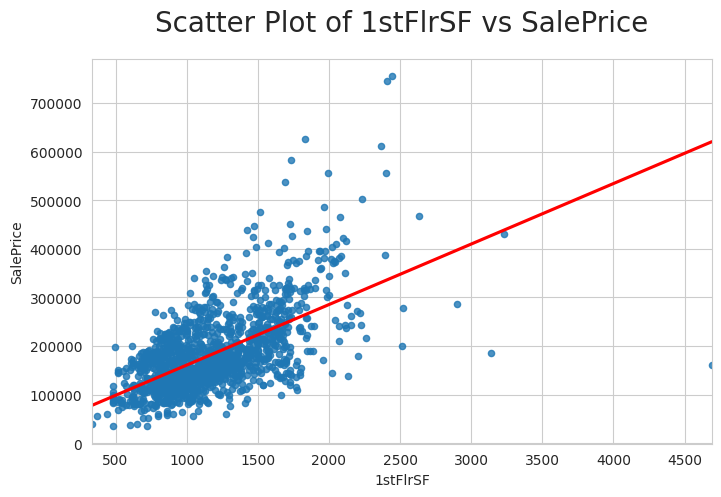

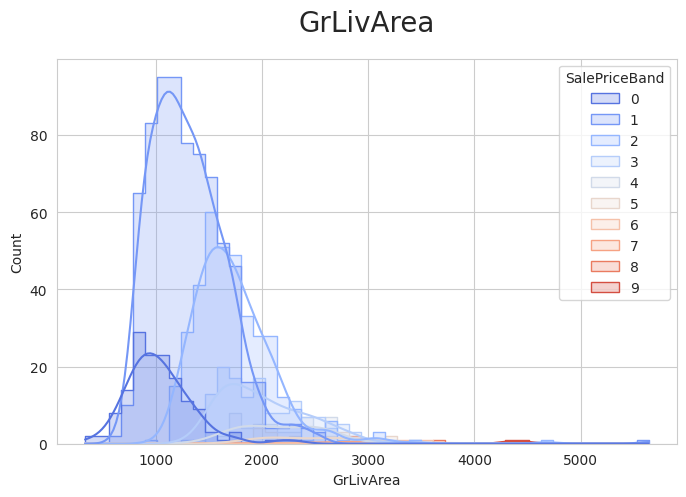

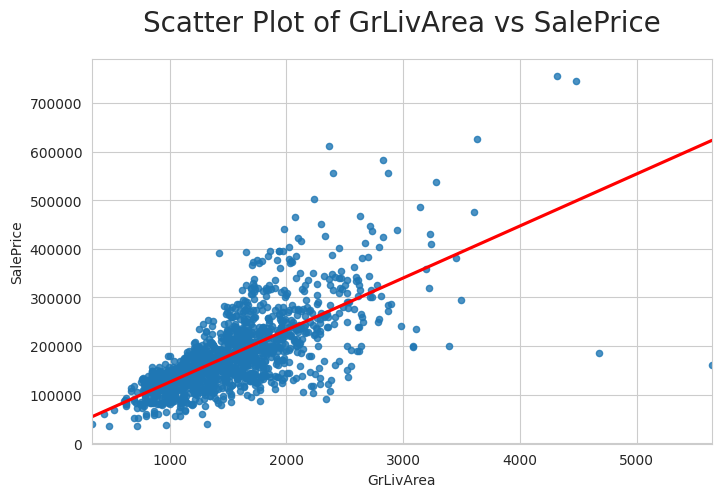

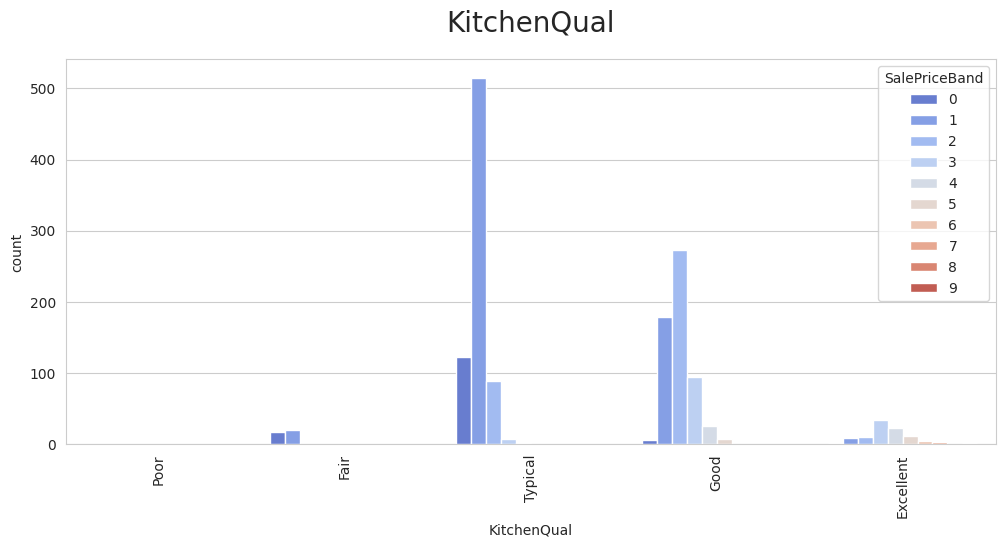

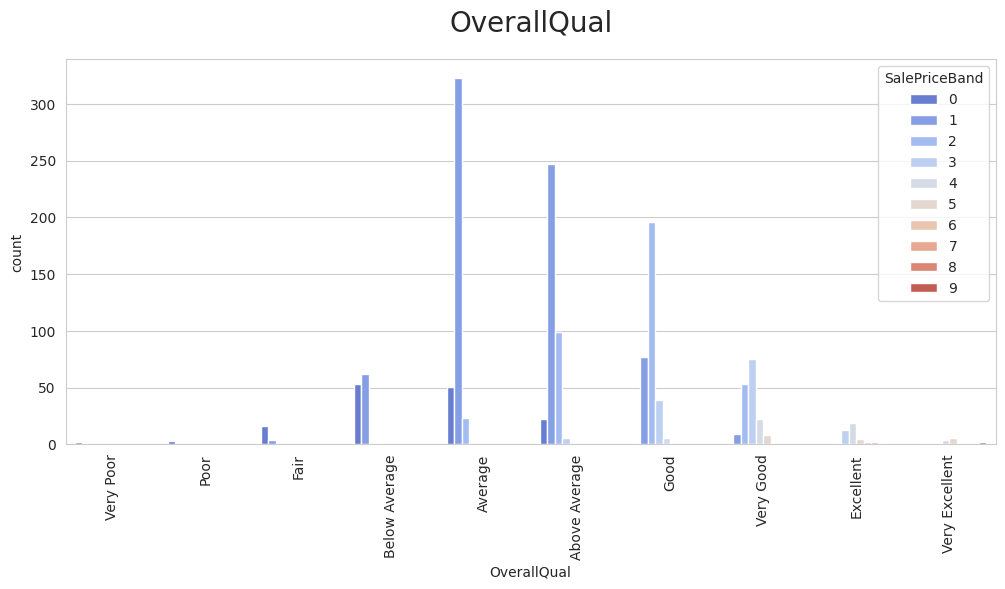

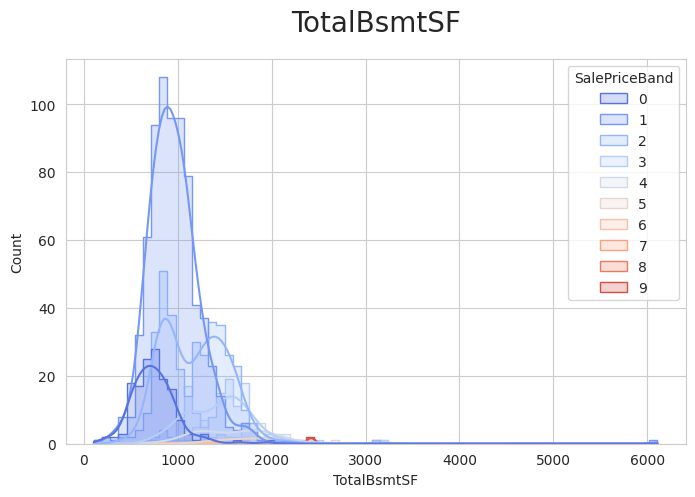

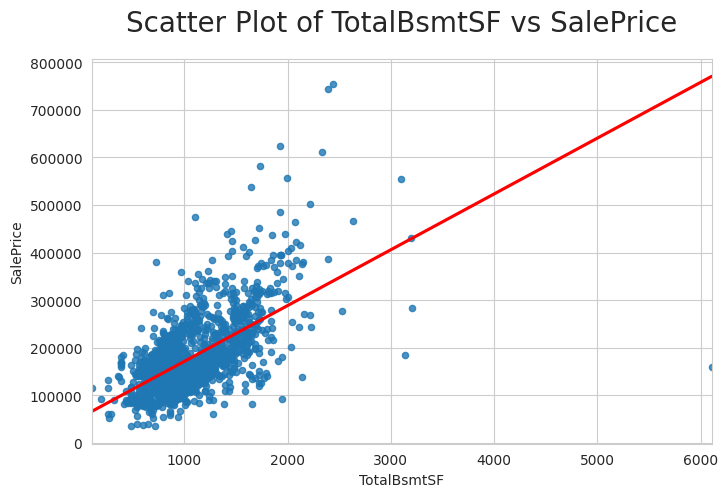

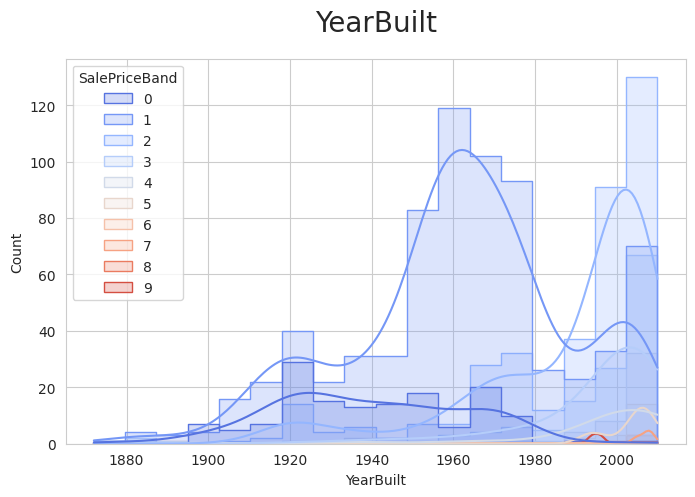

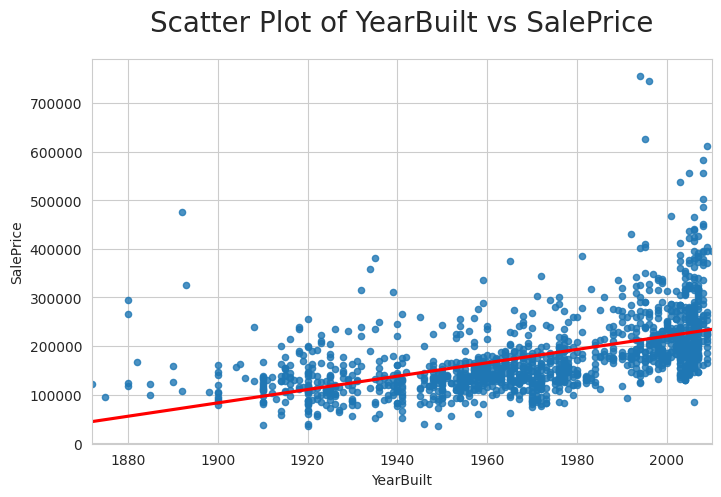

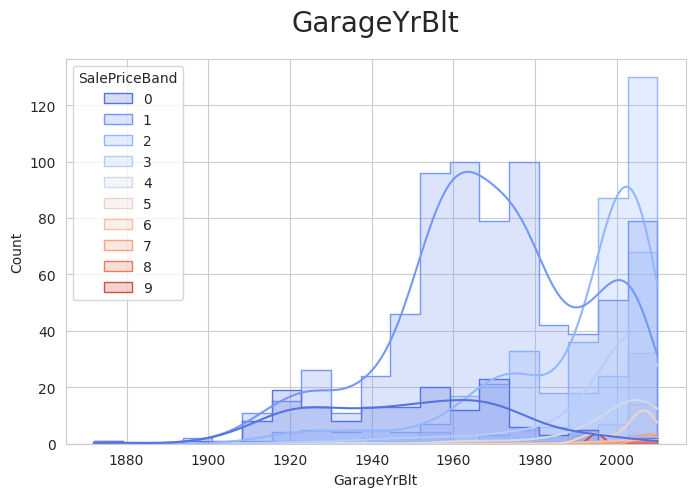

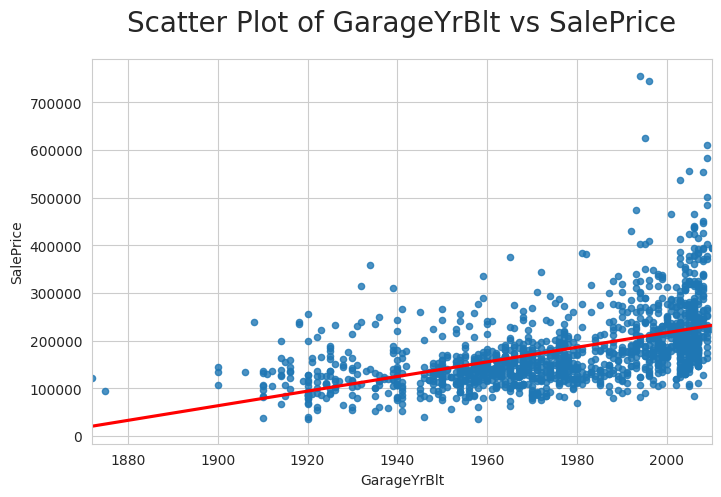

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

palette = sns.color_palette("coolwarm", 10)

# Defining the label mappings for KitchenQual and OverallQual
kitchen_qual_mapping = {4: 'Excellent', 3: 'Good', 2: 'Typical', 1: 'Fair', 0: 'Poor'}
overall_qual_mapping = {1: 'Very Poor', 2: 'Poor', 3: 'Fair', 4: 'Below Average',
                        5: 'Average', 6: 'Above Average', 7: 'Good',
                        8: 'Very Good', 9: 'Excellent', 10: 'Very Excellent'}

def plot_categorical(df_houseprices_eda, col, target_var, label_mapping=None, categories_order=None):
    plt.figure(figsize=(12, 5))
    sns.countplot(data=df_houseprices_eda, hue='SalePriceBand', x=col, palette=palette, order=categories_order)

    # Setting x-tick labels using the label mapping for KitchenQual and OverallQual
    if label_mapping:
        tick_labels = [label_mapping.get(val, val) for val in categories_order]
        plt.xticks(ticks=range(len(categories_order)), labels=tick_labels, rotation=90)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()

# Ensuring full range of categories (even with zero values)
kitchen_qual_order = sorted(kitchen_qual_mapping.keys())
overall_qual_order = sorted(overall_qual_mapping.keys())

def plot_numerical(df_houseprices_eda, col, target_var, label_mapping=None):
    plt.figure(figsize=(8, 5))
    
    # Plot histogram for the single numerical variable
    sns.histplot(data=df_houseprices_eda, x=col, kde=True, hue='SalePriceBand', element="step", palette=palette)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()

def plot_scatter_with_correlation(df_houseprices_eda, x_col, y_col):
    """Plots scatter plot between two numerical variables with a regression line"""
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df_houseprices_eda, x=x_col, y=y_col, scatter_kws={"s": 20}, line_kws={"color": "red"}, ci=None)
    plt.title(f"Scatter Plot of {x_col} vs {y_col}", fontsize=20, y=1.05)
    plt.show()

# Visualisation loop
target_var = 'SalePrice'
for col in vars_to_display:
    if col == 'KitchenQual':
        plot_categorical(df_houseprices_eda, col, target_var, label_mapping=kitchen_qual_mapping, categories_order=kitchen_qual_order)
    elif col == 'OverallQual':
        plot_categorical(df_houseprices_eda, col, target_var, label_mapping=overall_qual_mapping, categories_order=overall_qual_order)
    elif df_houseprices_eda[col].dtype == 'object':
        plot_categorical(df_houseprices_eda, col, target_var)
    else:
        plot_numerical(df_houseprices_eda, col, target_var)

        # Add scatter plot with correlation line for numerical variables (e.g., SalePrice vs another numerical column)
        plot_scatter_with_correlation(df_houseprices_eda, col, target_var)

In [102]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# sns.set_style('whitegrid')

# palette = sns.color_palette("coolwarm", 10)

# # Defining the label mappings for KitchenQual and OverallQual
# kitchen_qual_mapping = {4: 'Excellent', 3: 'Good', 2: 'Typical', 1: 'Fair', 0: 'Poor'}
# overall_qual_mapping = {1: 'Very Poor', 2: 'Poor', 3: 'Fair', 4: 'Below Average',
#                         5: 'Average', 6: 'Above Average', 7: 'Good',
#                         8: 'Very Good', 9: 'Excellent', 10: 'Very Excellent'}

# def plot_categorical(df_houseprices, col, target_var, label_mapping=None, categories_order=None):
#     plt.figure(figsize=(12, 5))
#     sns.countplot(data=df_houseprices, hue='SalePriceBand', x=col, palette=palette, order=categories_order)

#     # Setting x-tick labels using the label mapping for KicthenQual and OverallQual
#     if label_mapping:
#         tick_labels = [label_mapping.get(val, val) for val in categories_order]
#         plt.xticks(ticks=range(len(categories_order)), labels=tick_labels, rotation=90)
#     plt.title(f"{col}", fontsize=20, y=1.05)
#     plt.show()

# # Ensuring full range of categories (even with zero values)
# kitchen_qual_order = sorted(kitchen_qual_mapping.keys())
# overall_qual_order = sorted(overall_qual_mapping.keys())

# def plot_numerical(df_houseprices, col, target_var, label_mapping=None):
#     plt.figure(figsize=(8, 5))
#     sns.histplot(data=df_houseprices, x=col, kde=True, hue='SalePriceBand', element="step", palette=palette)
#     plt.title(f"{col}", fontsize=20, y=1.05)
#     plt.show()

# # Visualisation loop
# target_var = 'SalePrice'
# for col in vars_to_display:
#     if col == 'KitchenQual':
#         plot_categorical(df_houseprices_eda, col, target_var, label_mapping=kitchen_qual_mapping, categories_order=kitchen_qual_order)
#     elif col == 'OverallQual':
#         plot_categorical(df_houseprices_eda, col, target_var, label_mapping=overall_qual_mapping, categories_order=overall_qual_order)
#     elif df_houseprices_eda[col].dtype == 'object':
#         plot_categorical(df_houseprices_eda, col, target_var)
#     else:
#         plot_numerical(df_houseprices_eda, col, target_var)



#### *Observations*

*

# Correlation and Heatmap for All variables

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  462.0  0.039  0.088  0.0  0.0  0.0  0.034  0.702


* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



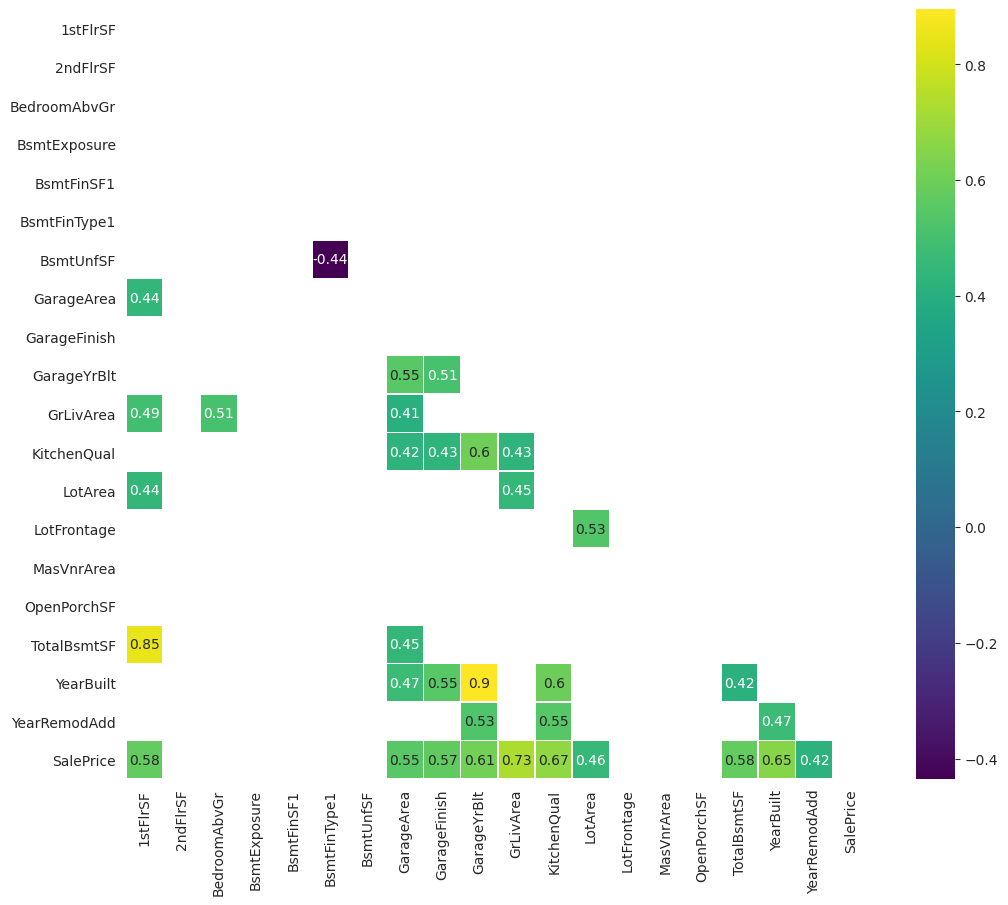



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



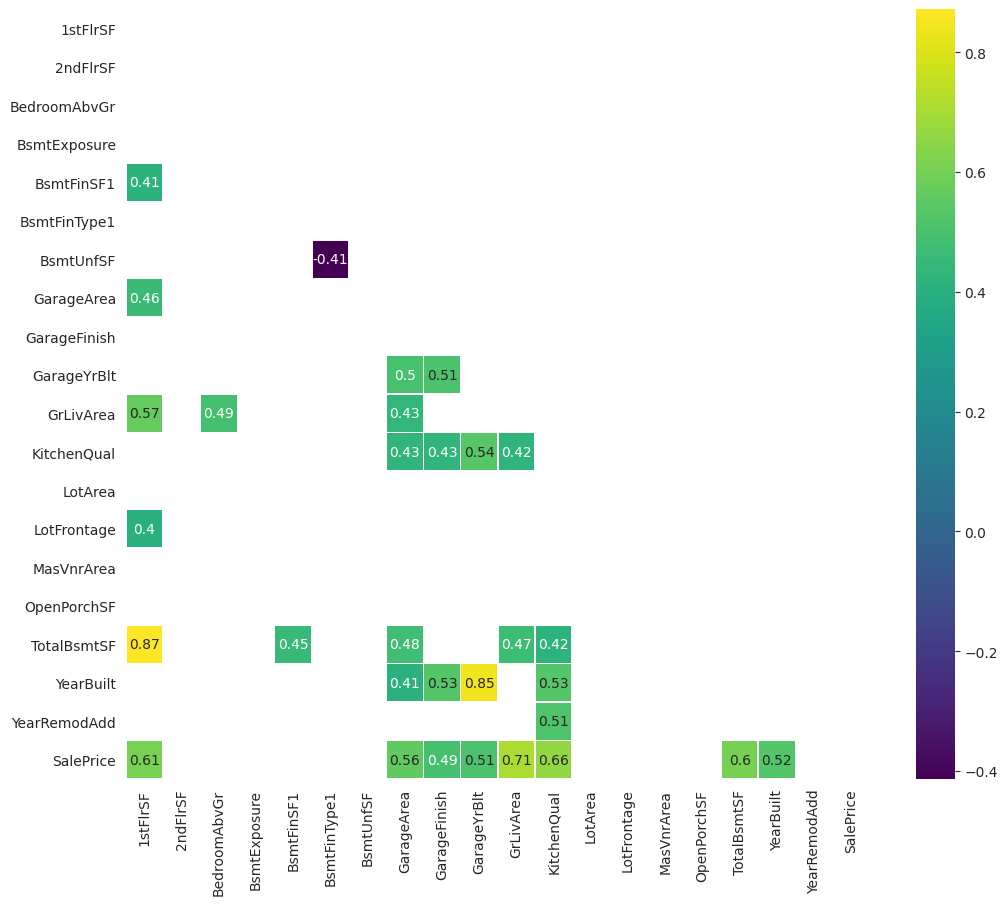



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



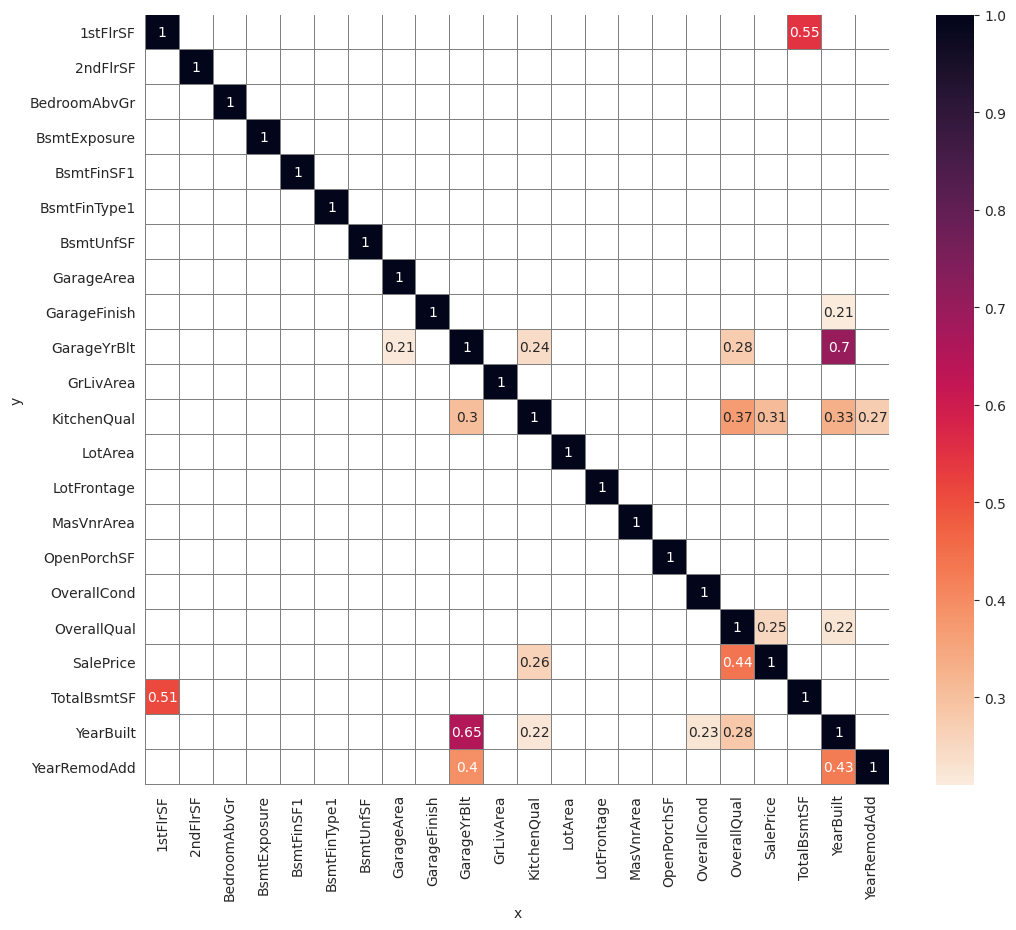

In [103]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps


def heatmap_corr(df_houseprices, threshold, figsize=(20, 12), font_annot=8):
  if len(df_houseprices.columns) > 1:
    mask = np.zeros_like(df_houseprices, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    mask[abs(df_houseprices) < threshold] = True

    fig, axes = plt.subplots(figsize=figsize)
    sns.heatmap(df_houseprices, annot=True, xticklabels=True, yticklabels=True,
          mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
          linewidth=0.5
          )
    axes.set_yticklabels(df_houseprices.columns, rotation=0)
    plt.ylim(len(df_houseprices.columns), 0)
    plt.show()


def heatmap_pps(df_houseprices, threshold, figsize=(20, 12), font_annot=8):
  if len(df_houseprices.columns) > 1:
    mask = np.zeros_like(df_houseprices, dtype=np.bool)
    mask[abs(df_houseprices) < threshold] = True
    fig, ax = plt.subplots(figsize=figsize)
    ax = sns.heatmap(df_houseprices, annot=True, xticklabels=True, yticklabels=True,
             mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
             linewidth=0.05, linecolor='grey')
    plt.ylim(len(df_houseprices.columns), 0)
    plt.show()


def CalculateCorrAndPPS(df_houseprices):
  df_corr_spearman = df_houseprices.corr(method="spearman")
  df_corr_pearson = df_houseprices.corr(method="pearson")

  pps_matrix_raw = pps.matrix(df_houseprices)
  pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

  pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
  print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
  print(pps_score_stats.round(3))

  return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
           figsize=(20, 12), font_annot=8):

  print("\n")
  print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
  print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

  print("\n")
  print("*** Heatmap: Spearman Correlation ***")
  print("It evaluates monotonic relationship \n")
  heatmap_corr(df_houseprices=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Pearson Correlation ***")
  print("It evaluates the linear relationship between two continuous variables \n")
  heatmap_corr(df_houseprices=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

  print("\n")
  print("*** Heatmap: Power Predictive Score (PPS) ***")
  print(f"PPS detects linear or non-linear relationships between two columns.\n"
     f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
  heatmap_pps(df_houseprices=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df_houseprices)

DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
         df_corr_spearman = df_corr_spearman, 
         pps_matrix = pps_matrix,
         CorrThreshold = 0.4, PPS_Threshold =0.2,
         figsize=(12,10), font_annot=10)


---

# Save as new Clean dataset

In [104]:
# Save as file in collections folder

import os
try:
  os.makedirs(name='outputs/datasets/cleaned')
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/datasets/cleaned'


In [105]:
df_houseprices.to_csv("outputs/datasets/cleaned/HousePricesClean.csv", index=False)

# Conclusions and Next Steps

---

### Saving key information from notebook

In [106]:
import joblib
import os

version = 'v1'
file_path = f'outputs/images/{version}'

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)

[Errno 17] File exists: 'outputs/images/v1'


### Dataset

### Scatterplots and distribution of key variables

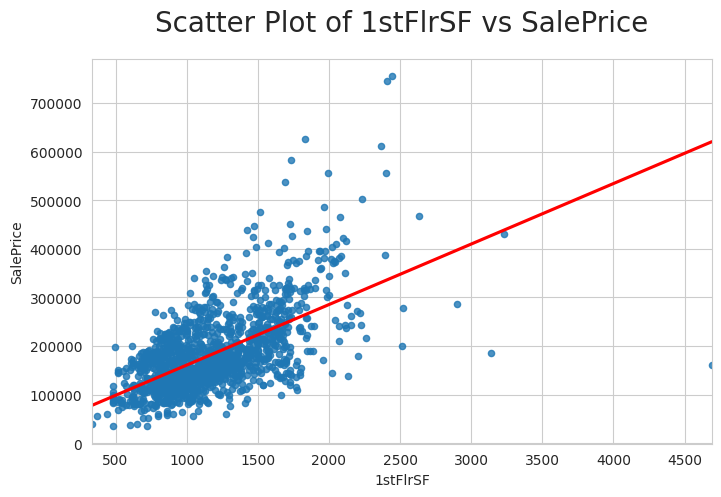

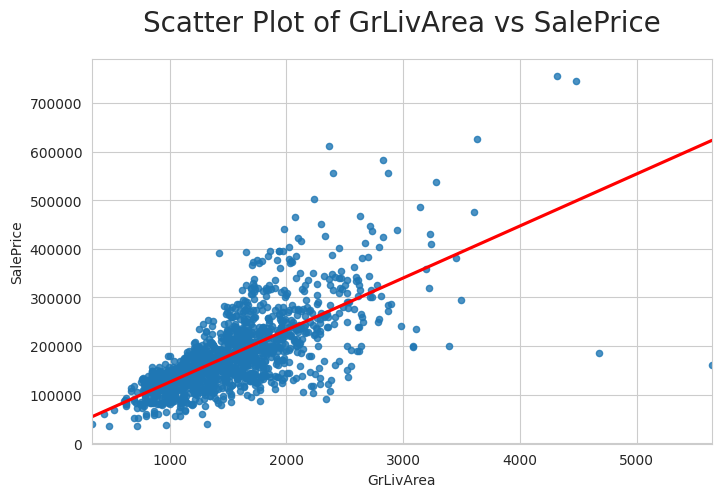

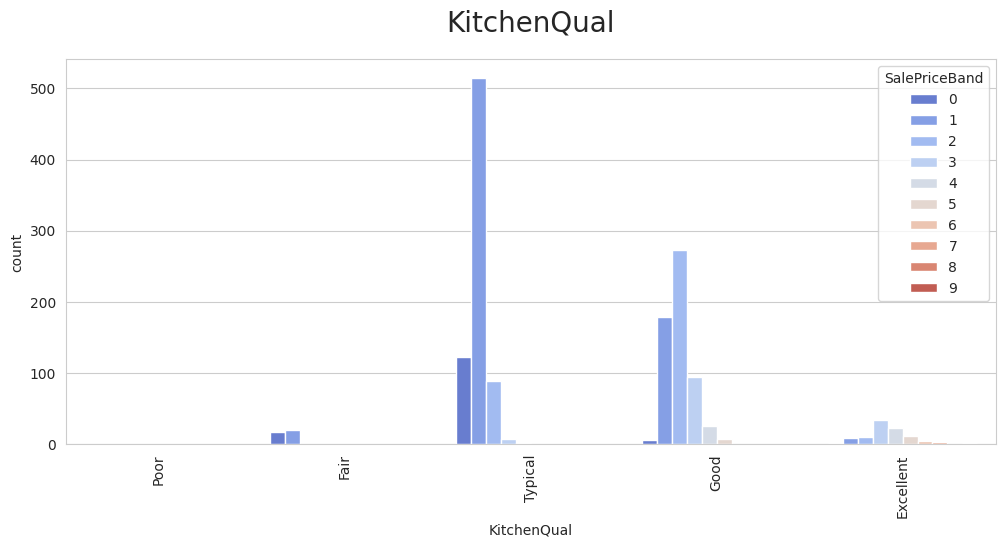

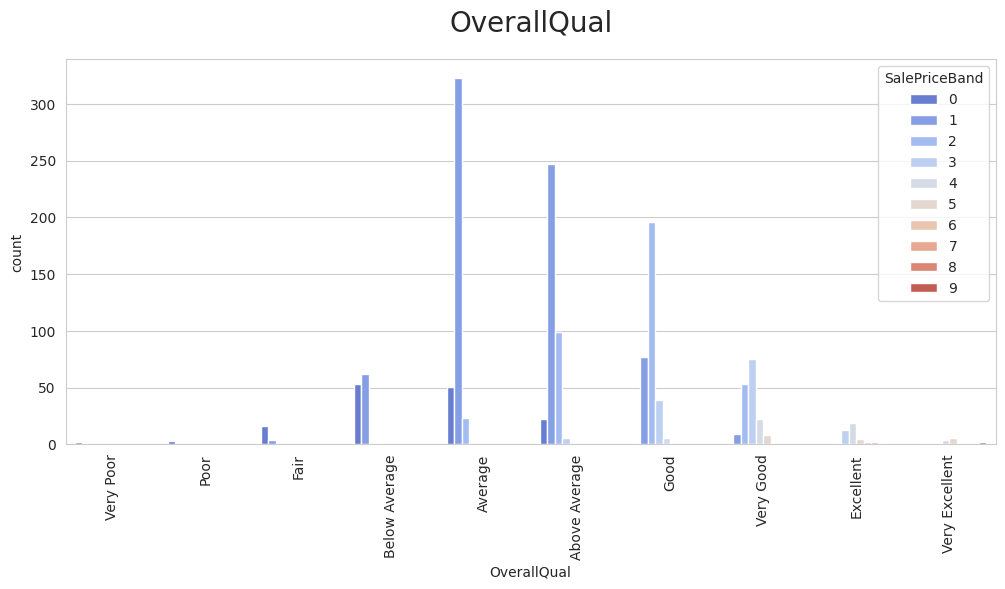

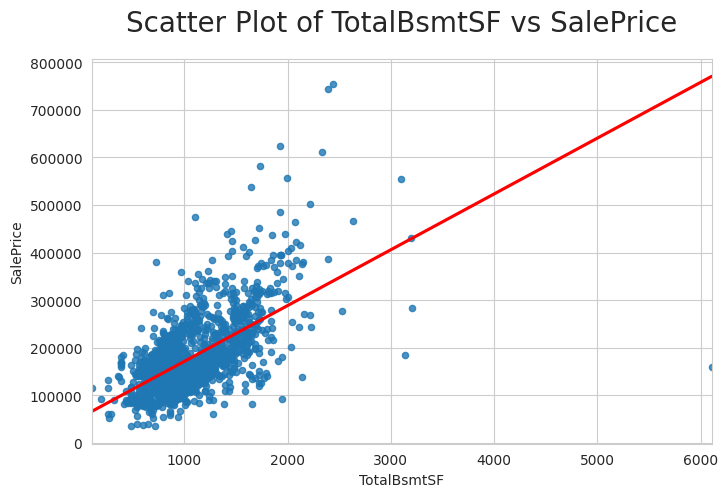

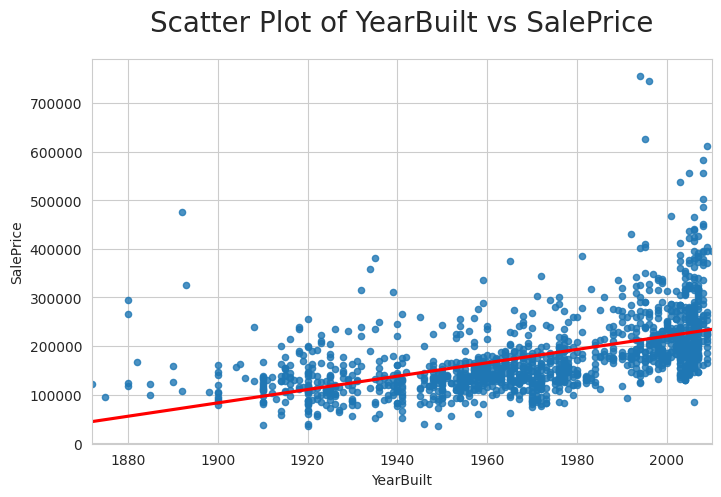

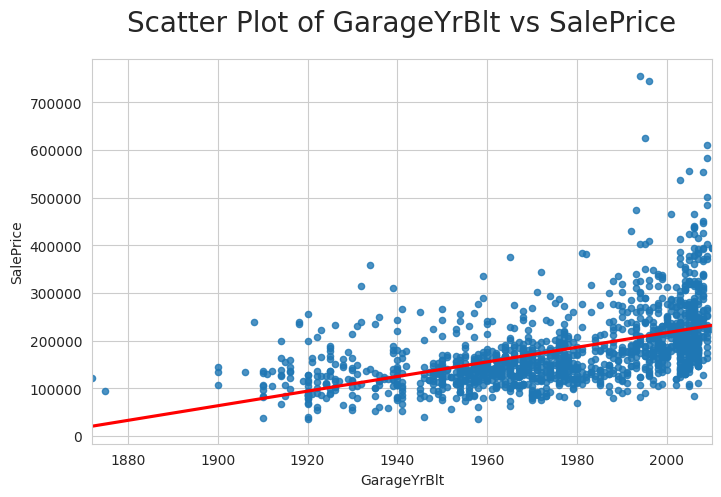

<Figure size 640x480 with 0 Axes>

In [107]:
target_var = 'SalePrice'
for col in vars_to_display:
    if col == 'KitchenQual':
        plot_categorical(df_houseprices_eda, col, target_var, label_mapping=kitchen_qual_mapping, categories_order=kitchen_qual_order)
    elif col == 'OverallQual':
        plot_categorical(df_houseprices_eda, col, target_var, label_mapping=overall_qual_mapping, categories_order=overall_qual_order)
    elif df_houseprices_eda[col].dtype == 'object':
        plot_categorical(df_houseprices_eda, col, target_var)
    else:
        plot_scatter_with_correlation(df_houseprices_eda, col, target_var)

plt.savefig(f'{file_path}/scatter_distribution_corr_vars.png', bbox_inches='tight')

In [108]:
X_train.head()

NameError: name 'X_train' is not defined

In [ ]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [ ]:
y_train.head()

618    314813
870    109500
92     163500
817    271000
302    205000
Name: SalePrice, dtype: int64

In [ ]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set: features and target

In [ ]:
X_test.head()

,OverallQual,GrLivArea,GarageArea,YearBuilt,TotalBsmtSF,LotArea
529,6,2515,484,1957,2035,32668
491,6,1578,240,1941,806,9490
459,5,1203,352,1950,709,7015
279,7,2022,505,1977,1160,10005
655,6,1092,264,1971,525,1680


In [ ]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [ ]:
y_test.head()

529    200624
491    133000
459    110000
279    192000
655     88000
Name: SalePrice, dtype: int64

In [ ]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### Modelling pipeline

In [ ]:
pipeline_best

Pipeline(steps=[('SmartCorrelatedSelection',
                 SmartCorrelatedSelection(method='spearman',
                                          selection_method='variance',
                                          threshold=0.6,
                                          variables=['OverallQual', 'GrLivArea',
                                                     'GarageArea', 'YearBuilt',
                                                     'TotalBsmtSF',
                                                     'LotArea'])),
                ('feat_scaling', StandardScaler()),
                ('model',
                 ExtraTreesRegressor(max_features='sqrt', min_samples_split=5,
                                     n_estimators=300, random_state=0))])

In [ ]:
joblib.dump(value=pipeline_clf, filename=f"{file_path}/pipeline_best.pkl")

['outputs/ml_pipeline/regression_analysis/v1/pipeline_best.pkl']

## Feature importance plot

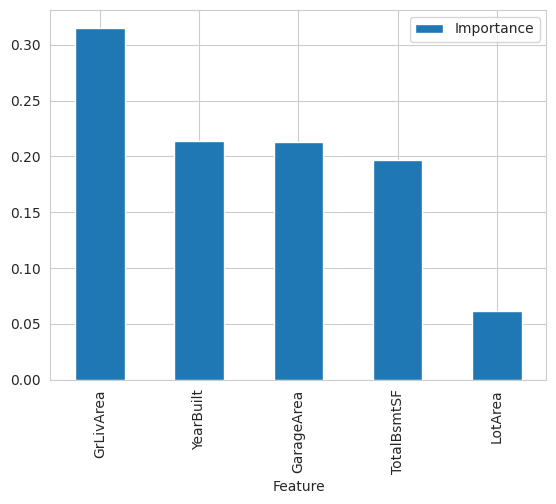

In [ ]:
df_feature_importance.plot(kind='bar',x='Feature',y='Importance')
plt.savefig(f'{file_path}/features_importance.png', bbox_inches='tight')